⭐ **Поздравляем** — вы научились строить решающие пни как для задачи регрессии, так и для задачи классификации. От финального алгоритма построения дерева решений по методу CART нас отделяет последний шаг. Нам осталось ответить на один вопрос: как обобщить полученный алгоритм построения решающего пня для деревьев произвольной глубины?

**Небольшое, но важное лирическое отступление.** Легко убедиться, что для любой выборки можно построить решающее дерево, не допускающее на ней ни одной ошибки. Даже с простыми предикатами $[x_j <= t]$ можно сформировать дерево, в каждом листе которого находится ровно по одному объекту выборки. По своему практическому опыту мы уже знаем, что, скорее всего, это дерево будет переобученным из-за слишком большого количества листьев, и выглядеть оно будет примерно так:

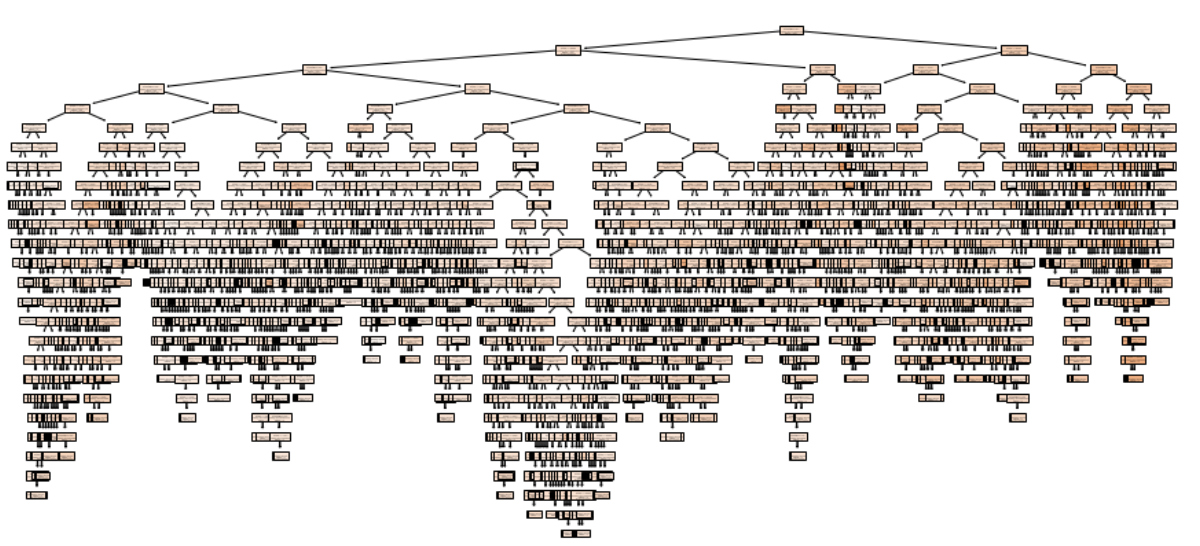

Очевидно, что настолько громоздкие деревья нам не подойдут.

Тогда можно было бы поставить задачу поиска дерева, которое является минимальным (с точки зрения количества листьев) среди всех деревьев, не допускающих ошибок на обучении — в этом случае можно было бы надеяться на наличие у дерева обобщающей способности. К сожалению, было доказано, что эта задача является слишком сложной (если быть точнее, NP-полной), а время построения дерева неприемлемо велико.

Как тогда быть? Придётся отказаться от идеи поиска оптимальной структуры дерева. Будем искать не всю структуру дерева целиком, а строить его уровень за уровнем, последовательно.

Схематично поэтапное построение дерева решений выглядит следующим образом:

*Допустим, мы построили решающий пень. В результате построения получилась одна родительская и две дочерние вершины, каждой из которых соответствует своя часть исходной выборки.*

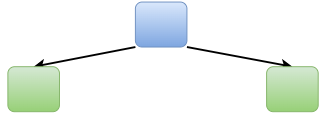

*Чтобы построить следующий уровень дерева, необходимо проделать ту же процедуру построения решающего пня, но теперь уже каждая из дочерних вершин воспринимается как родительская, и её основе строится новый решающий пень. В результате получится дерево глубиной 2.*

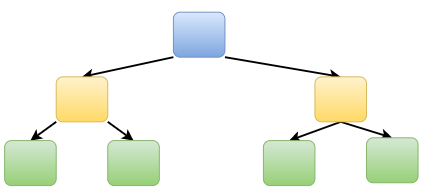

*Строим следующий уровень: дочерние вершины снова воспринимаем как родительские и на их основе строим новые решающие пни. Получаем дерево глубиной 3.*

*Повторяем эти действия, пока не дойдём до некоторого предела, на котором нужно будет остановиться: например, если мы достигли идеальной однородности (все объекты относятся к одному классу).*

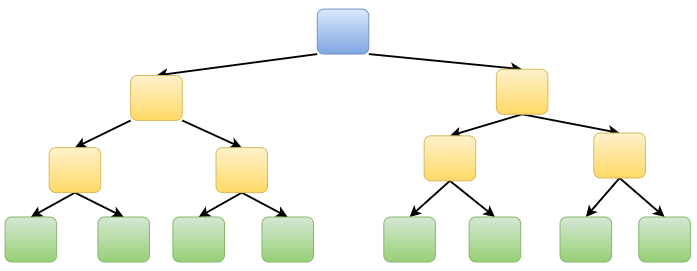



### **Примечание.** Формально такой последовательный алгоритм построения дерева относится к категории жадных алгоритмов.

Внимательные студенты уже догадались, что описанная нами процедура построения дерева является **рекурсией**. Мы рекурсивно используем алгоритм построения решающего пня для каждой из дочерних вершин, тем самым создавая всё новые и новые вершины графа.

Теперь давайте переведём наши рассуждения на язык математики и сформулируем итоговый алгоритм построения дерева.

### **Примечание.** Отметим, что, так как мы теперь рассматриваем не решающие пни, а деревья произвольной глубины, то в наших рассуждениях появится **индекс вершины дерева** $v$. Он вводится для того, чтобы обозначить, что та или иная величина рассчитывается для конкретной вершины.

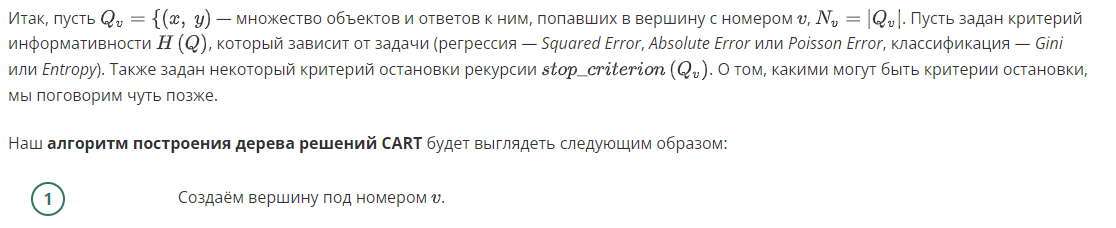
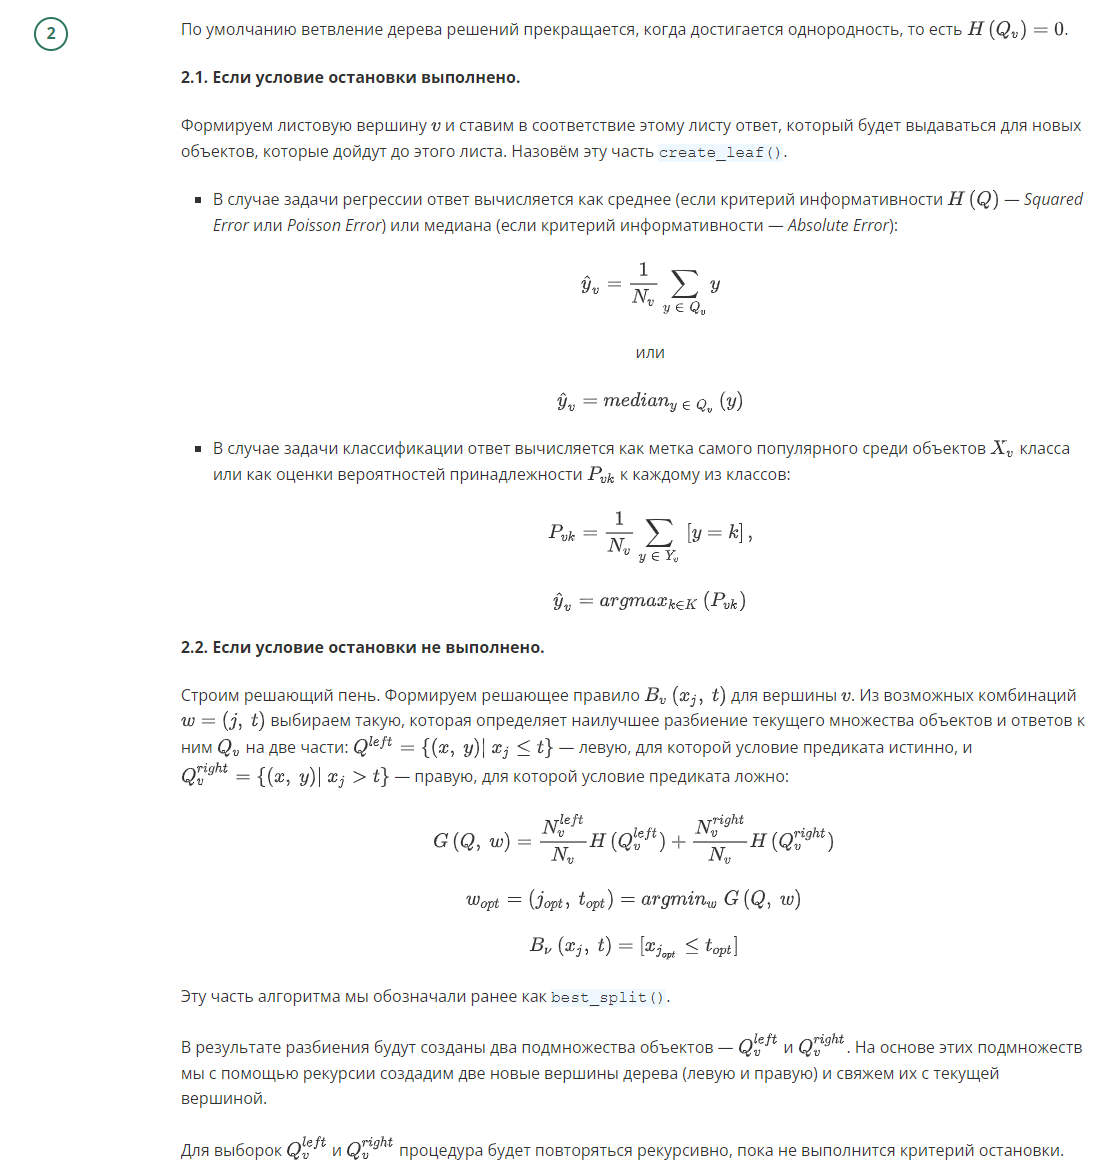
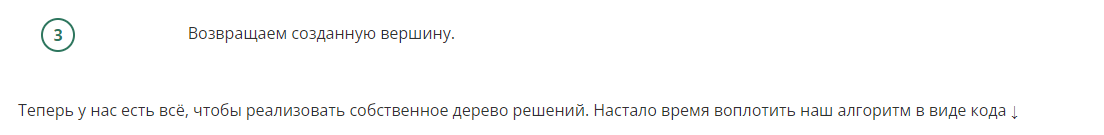

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params    

def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy



Для начала создадим вспомогательный класс вершины. У него будут следующие атрибуты:

+ left — ссылка на левого потомка;
+ right — ссылка на правого потомка;
+ value — ответ алгоритма;
+ split_params — параметры разбиения (сплита);
+ impurity — неоднородность в вершине (пригодится для расчёта важности признаков);
+ samples — количество объектов, попавших в вершину;
+ is_leaf — булева переменная, которая указывает, является ли вершина корневой.

По умолчанию все параметры заданы как None.

In [81]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

+ Если вершина является корневой или внутренней, для неё устанавливаются ссылки на потомков, параметры разбиения, неоднородность и количество объектов.
+ Если вершина является листовой, для неё указываются только ответ, неоднородность и количество объектов, а параметр is_leaf устанавливается в значение True.

Для случая задачи классификации ответ — это класс с наибольшей вероятностью, иначе говоря, самый популярный класс. Мы знаем, что самое популярное значение — это мода, а в Pandas как раз есть функция, которая позволяет вычислять её в одну строку кода, — mode(). Помним, что мод может быть несколько — нам нужна любая из них, поэтому мы берём первое значение из списка.

Реализуем эту часть в виде функции create_leaf_prediction(). Она будет принимать на вход целевую переменную y и возвращать модальное значение:

In [82]:
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

Далее введём критерий остановки. Самый базовый критерий — равенство нулю критерия информативности, рассчитанного по вершине.

In [83]:
def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

Наконец, создадим функцию build_decision_tree(). Она будет реализовывать сам рекурсивный алгоритм построения дерева решений. Функция будет принимать на вход выборку X и y, а также критерий информативности. На выходе функции должна быть корневая вершина дерева (объект класса Node). Она будет ссылаться на своих левого и правого потомка, они в свою очередь будут ссылаться на своих потоков, и так далее до самых листьев.

In [84]:
def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    
    return node

Также напишем вспомогательную функцию print_decision_tree(). Она будет принимать на вход корневую вершину дерева решений и рекурсивно выводить дерево решений в виде текста:

In [85]:
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)

Давайте обучим наше дерево решений на игрушечном датасете о выдаче кредитов клиентам банка и напечатаем его. Напомним, что у нас есть два фактора: $x_1$ — возраст заёмщика, $x_2$ — доход заёмщика. Целевая переменная $y$ — бинарная (0 — кредит погашен, 1 — кредит не погашен).

In [86]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


Давайте сравним наш результат с деревом решений из sklearn, напечатав его в текстовом виде с помощью функции export_text() из модуля tree. Не будем ограничивать глубину дерева, а в качестве значения параметра random_state возьмём 1000 для совпадения результатов:

In [87]:
# Создаём модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Выводим дерево решений на экран в виде списка условий
print(tree.export_text(decision_tree=dt))

|--- feature_0 <= 43.50
|   |--- feature_1 <= 86.00
|   |   |--- feature_0 <= 22.50
|   |   |   |--- feature_0 <= 19.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  19.00
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  22.50
|   |   |   |--- class: 1
|   |--- feature_1 >  86.00
|   |   |--- class: 0
|--- feature_0 >  43.50
|   |--- class: 0



Мы своими руками реализовали алгоритм построения деревьев решений CART и получили такое же дерево, как в sklearn (исключая линии разметки).

Как вы понимаете, построить дерево решений мало — нужно ещё научить его предсказывать целевую переменную для новых объектов. Для этого реализуем две функции:

+ predict_sample() принимает на вход вершину и один объект из выборки x. Алгоритм предсказания следующий: нужно рекурсивно передвигаться по дереву на основе характеристик объекта (если $x[j] <= t$ — в левую вершину, иначе — в правую), а когда дойдём до листовой вершины, вернуть предсказание, которое присвоено этому листу (value).

In [88]:
def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

+ predict() принимает на вход дерево решений и матрицу из объектов X, для которых нужно сделать предсказание. Внутри себя функция должна сделать предсказание для всех объектов из X — вызвать функцию predict_sample(). Результат оборачивается в список, а затем в numpy-вектор.

In [89]:
def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

Проверим наши функции. Сделаем предсказание выплаты/невыплаты заёмщиком кредита для всех объектов из обучающей выборки:

In [90]:
# Предсказываем целевую переменную
y_pred = predict(decision_tree, X)
print('Predictions: {}'.format(y_pred))

Predictions: [1 0 1 0 1 0 0 1 1 0]


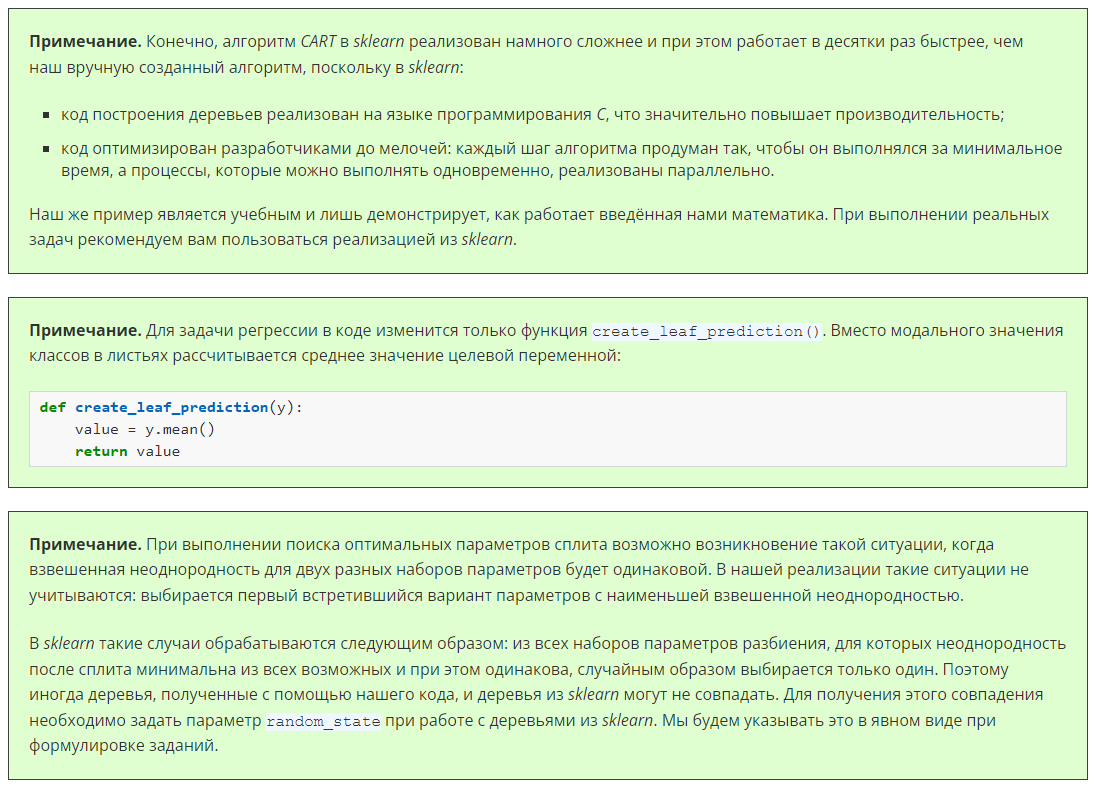



In [91]:
def create_leaf_prediction(y):
    value = y.mean()
    return value

## Задание 5.1

С помощью какого механизма происходит обобщение алгоритма построения решающего пня на случай дерева произвольной глубины?

+ Рекурсия

## Задание 5.2

Что происходит с вершиной дерева решений, для которой выполняется условие остановки?

+ Она превращается в лист, и алгоритм её деления завершается.


## Задание 5.3

Дана часть датасета о банкнотах, состоящая из 15 наблюдений:

In [75]:
bill_data = pd.read_csv('bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

Постройте дерево решений на обучающей выборке с помощью функции build_decision_tree(). В качестве критерия информативности используйте энтропию Шеннона.

**Примечание.** Для самопроверки обучите на данной части датасета дерево решений с неограниченной максимальной глубиной и визуализируйте его граф. Чтобы получить тот же результат, установите параметр random_state = 0.

1. Сколько вершин дерева используют в качестве признака разбиения фактор $x_1$ (Variance)?
2. Чему равна глубина полученного дерева?

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0.0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1.0
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0.0
                feature_0 > 0.988:
                   class: 1.0
       feature_0 > 2.756:
          class: 0.0
    feature_1 > 3.221:
       class: 0.0


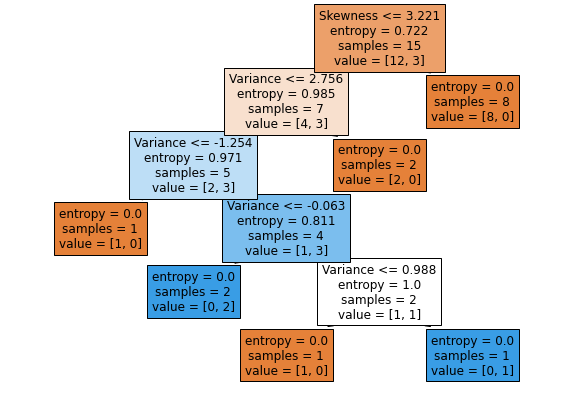

In [76]:
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeClassifier(max_depth=None, criterion='entropy', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

# **КРИТЕРИИ ОСТАНОВКИ**

## Как мы уже знаем, любая рекурсия всегда должна имеет **критерий остановки** — условие, при котором рекурсивный вызов прекращается.

В нашем случае также должно быть такое условие, а лучше целый набор условий, при которых ветвление дерева прекратится. В нашем алгоритме мы назвали данный шаг *stop_critetion* $(Q_v)$

В реализации дерева решений в sklearn предусмотрено несколько критериев, при выполнении одного из которых ветвление дерева прекращается. Мы рассмотрим основные из них на примере нашего «игрушечного» датасета о выплатах кредита.

In [94]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, np.NaN],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 40],
    'y': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]
})
# Создаём обучающую выборку
X = data[['age', 'income']]
y = data['y']

1. **ДОСТИЖЕНИЕ ОДНОРОДНОСТИ**

Этот критерий остановки мы уже использовали при построении своего дерева. Он является основным, то есть действует, если исследователем не установлены другие ограничения.

## Критерий гласит: ветвление дерева решений прекращается, когда неоднородность вершины, определяемая критерием информативности минимальна, то есть $H(Q) = 0$.

Для задачи **классификации** это условие означает, что все объекты в вершине являются объектами одного класса.

Для задачи **регрессии** это условие означает, что средняя ошибка предсказания вершины равна нулю.

Для примера построим дерево решений, используя наш «игрушечный» датасет. При этом все параметры оставим по умолчанию. Получим следующее дерево:



```
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);
```

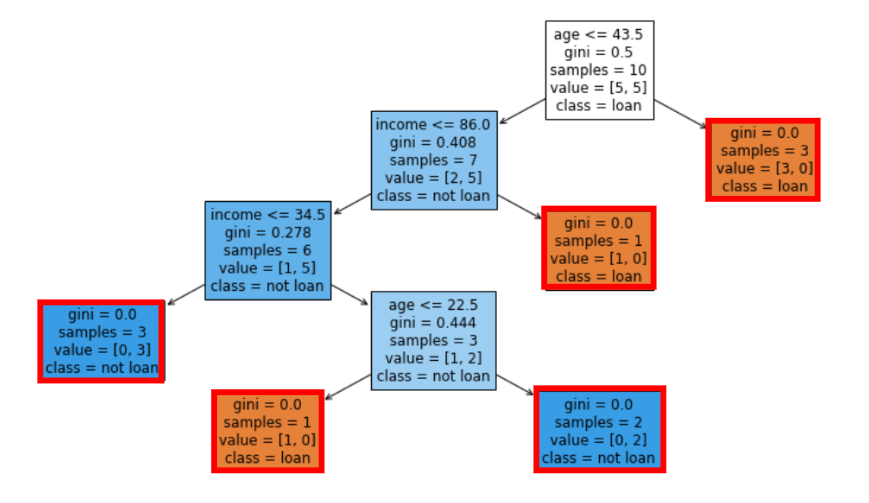

Обратите внимание, что во всех листовых вершинах (мы выделили их красным) неоднородность, обозначенная как gini, равна 0, а в самих листьях содержатся объекты (value) только одного определённого класса.

2. **ОГРАНИЧЕНИЕ МАКСИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА (ПАРАМЕТР MAX_DEPTH)**

Это самый простой критерий. Мы работали с ним уже десятки раз, используя деревья решений для задач классификации и регрессии.

## Идея состоит в том, что, когда дерево достигает максимально заданной глубины, ветвление прекращается. С точки зрения программной реализации, это означает ограничение глубины рекурсии.

По умолчанию глубина дерева не ограничена. Помните, что ограничение глубины дерева решений является основным методом борьбы с его переобучением.

В качестве примера ограничим глубину нашего дерева решений до 3:



```
dt = tree.DecisionTreeClassifier(
    max_depth=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);
```


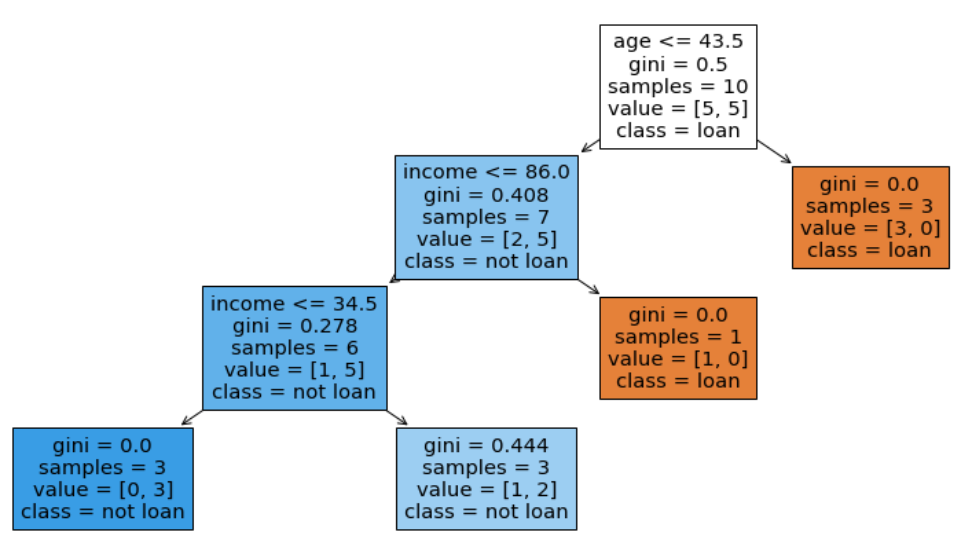

В результате мы получили обрезанную версию дерева, которое видели ранее.

3. **ОГРАНИЧЕНИЕ МАКСИМАЛЬНОГО КОЛИЧЕСТВА ЛИСТЬЕВ В ДЕРЕВЕ (ПАРАМЕТР MAX_LEAF_NODE)**

## Здесь всё происходит по аналогии с максимальной глубиной дерева: мы задаём максимальное количество листьев, которое может быть в дереве — когда количество листьев в дереве достигает этой верхней планки, ветвление прекращается.

По умолчанию количество листьев не ограничено. Как и все критерии остановки, ограничение на количество листьев может служить инструментом борьбы с переобучением дерева.

Для примера ограничим количество листьев в нашем дереве до 3:



```
dt = tree.DecisionTreeClassifier(
    max_leaf_nodes=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);
```

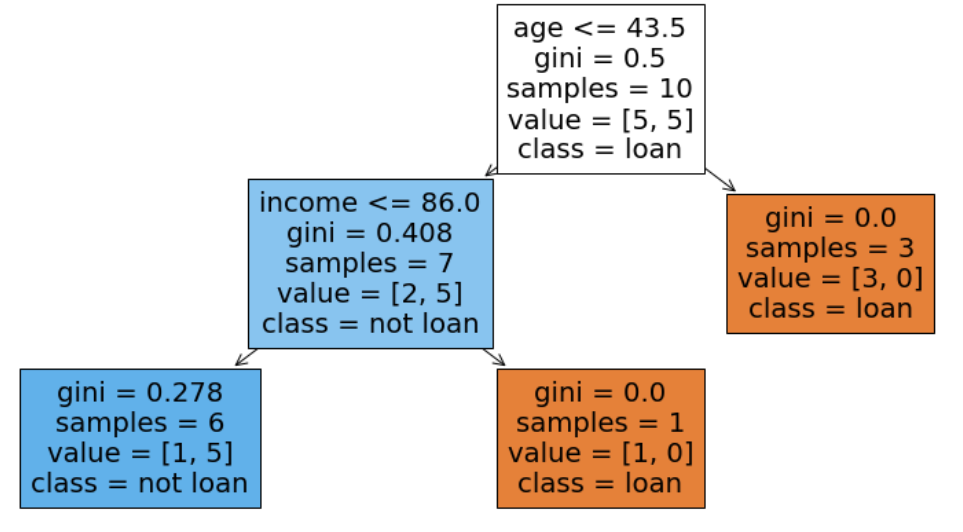

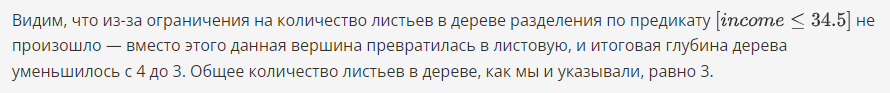




4. **ОГРАНИЧЕНИЕ НА МИНИМАЛЬНОЕ КОЛИЧЕСТВО ОБЪЕКТОВ, ПРИ КОТОРЫХ ДОПУСКАЕТСЯ ВЕТВЛЕНИЕ ДЕРЕВА (ПАРАМЕТР MIN_SAMPLES_SPLIT)**

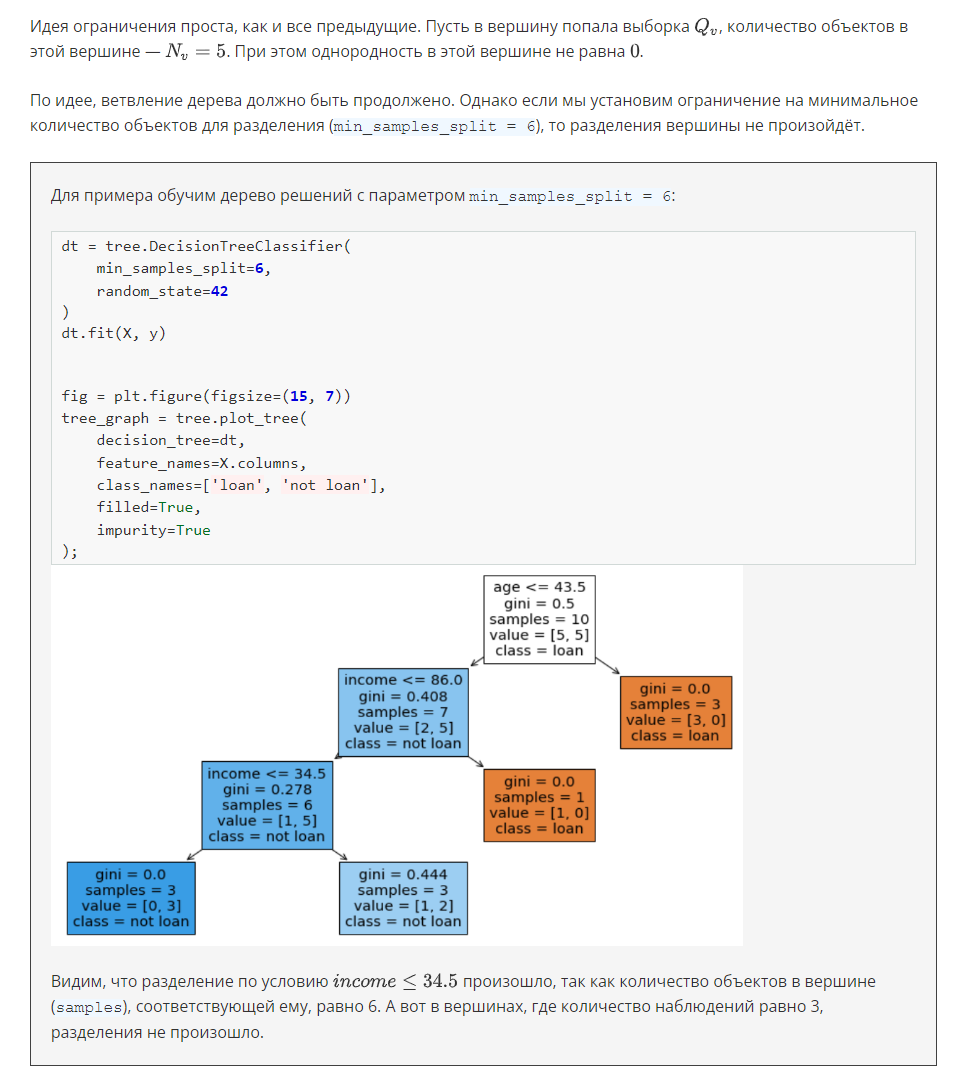

5. **ОГРАНИЧЕНИЕ НА МИНИМАЛЬНОЕ КОЛИЧЕСТВО ОБЪЕКТОВ, НЕОБХОДИМЫХ ДЛЯ СОЗДАНИЯ ЛИСТА (ПАРАМЕТР MIN_SAMPLES_LEAF)**

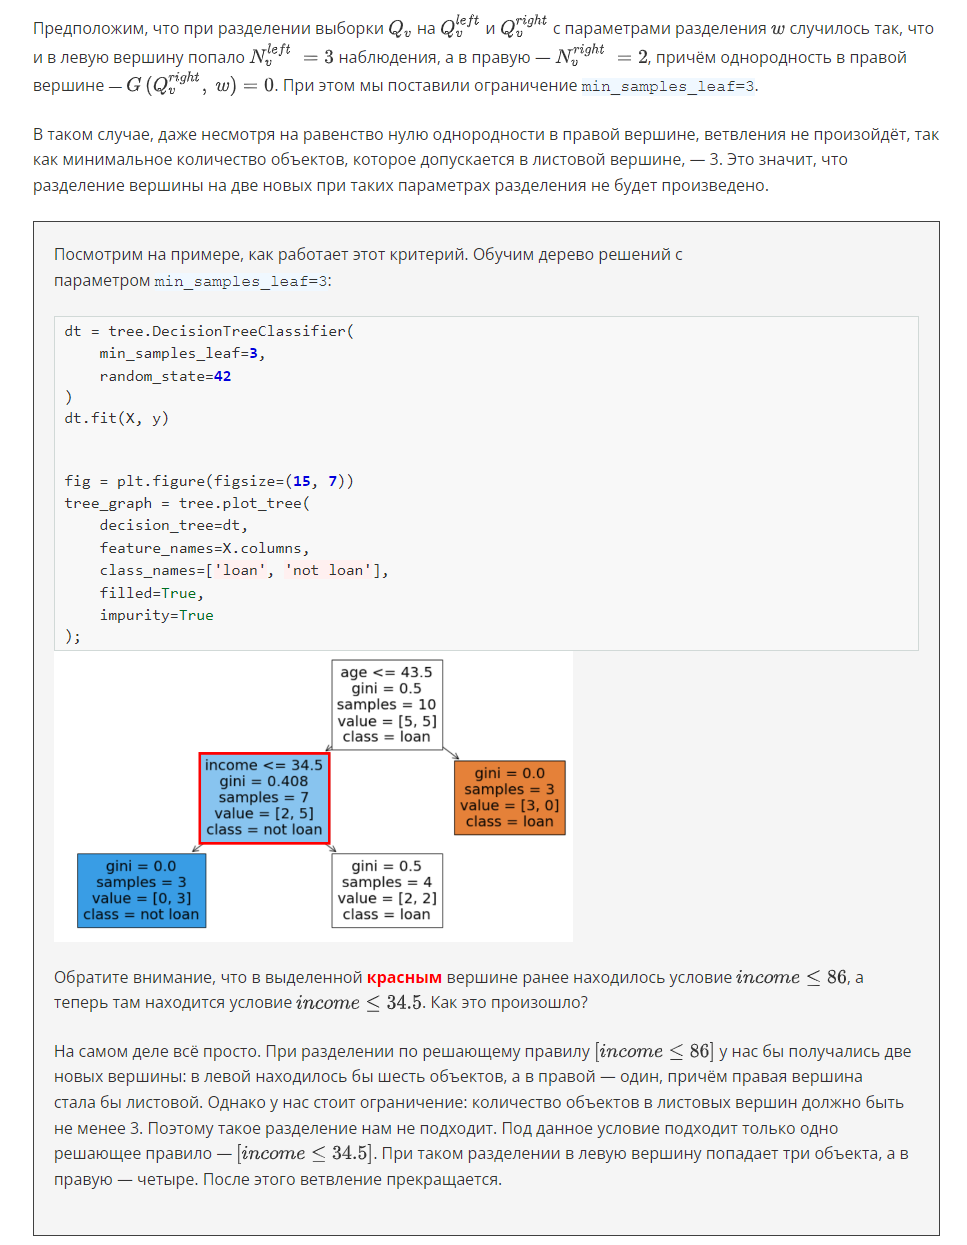

Давайте адаптируем наш метод построения дерева решений и введём новое ограничение на максимальную глубину дерева: в функции stop_criterion() и build_decision_tree() добавим параметр max_depth, а также счётчик глубины рекурсии depth:

In [95]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_rigth, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

Чтобы проверить результат, построим дерево с максимальной глубиной 2. В качестве данных используем данные о кредитах:

In [96]:
# Строим дерево решений с ограничением глубины и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_1 <= 72.000:
       feature_1 <= 34.500:
          class: 1.0
       feature_1 > 34.500:
          class: 0.6
    feature_1 > 72.000:
       class: 0.0


Видим, что глубина дерева уменьшилась до 2 — всё работает.

→ Как вы уже знаете, можно использовать одновременно несколько критериев остановки, тем самым управляя сложностью модели. Например, вы можете одновременно ограничивать и максимальную глубину (max_depth) и количество объектов, необходимых для разделения (min_samples_split). Однако, нельзя заранее сказать, какие внешние параметры дерева решений подойдут вам для решения конкретной задачи, поэтому используются знакомые вам методы подбора гиперпараметров, которые мы обсуждали в модуле ML-7. «Оптимизация гиперпараметров модели».

⭐ **Поздравляем!** Мы разобрали алгоритм построения дерева решений CART. Давайте **закрепим полученные знания ↓**

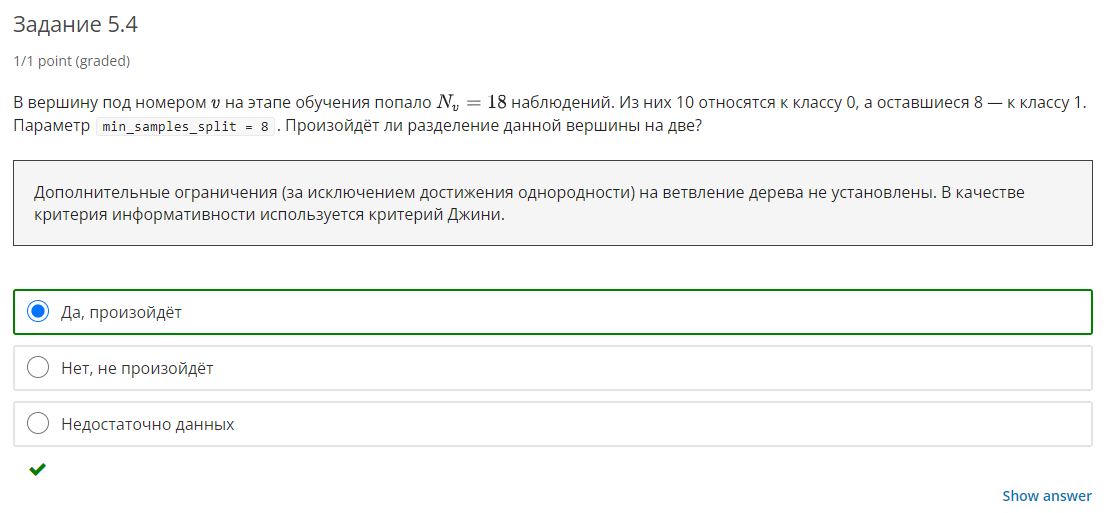

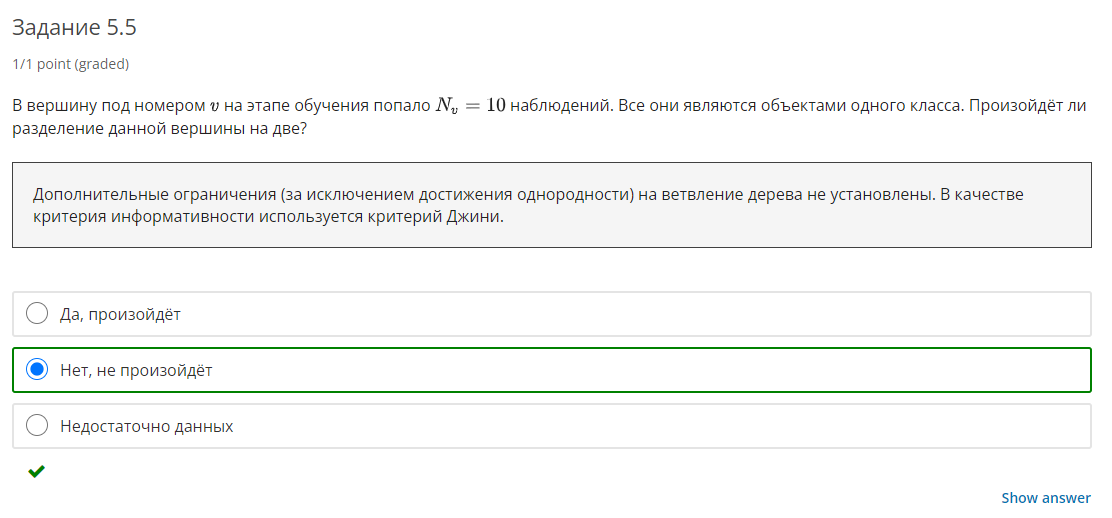

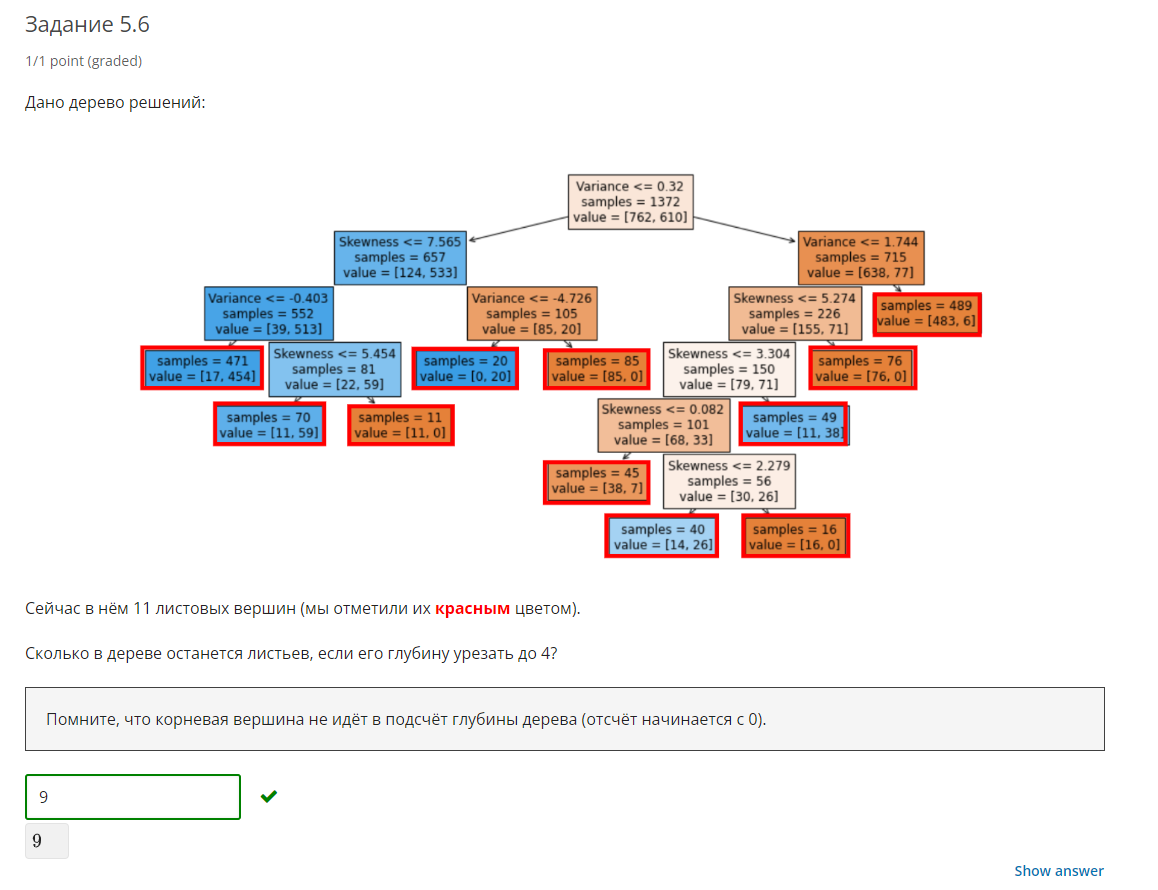